# Visualization Notebook

In [1]:
%matplotlib inline

from new_methods.new_methods import My_NuScenes
from new_methods.extended_methods import Extended_Nusenes
from tqdm import tqdm
import matplotlib.pyplot as plt
import numpy as np
import os.path as os
import pythreejs as pjs
import pickle
import math as mt

nusc = Extended_Nusenes(version='v1.0-mini', dataroot='/media/cwkim0214/HDD/datasets/nuscenes', verbose=True)

Loading NuScenes tables for version v1.0-mini...
23 category,
8 attribute,
4 visibility,
911 instance,
12 sensor,
120 calibrated_sensor,
31206 ego_pose,
8 log,
10 scene,
404 sample,
31206 sample_data,
18538 sample_annotation,
4 map,
Done loading in 0.318 seconds.
Reverse indexing ...
Done reverse indexing in 0.1 seconds.


# Visualize

In [5]:
#To Count total Points according for each filter condition
from new_methods.MyRadarPointCloud import MyRadarPointCloud

nsweeps = 1
total_pts = 0
ambig_pts = 0
invalid_pts = 0
dynprop_pts = 0
filtered_pts = 0

for index in tqdm(range(len(nusc.sample))):
    MyRadarPointCloud.disable_filters()
    total_radar_pc = nusc.make_points_list('r', index, nsweeps=nsweeps).astype(np.float32)
    total_pts += len(total_radar_pc)
    MyRadarPointCloud.removed_invalid_states()
    removed_invalid_pc = nusc.make_points_list('r', index, nsweeps=nsweeps).astype(np.float32)
    invalid_pts += len(removed_invalid_pc)
    MyRadarPointCloud.removed_dynprop_states()
    removed_dynprop_pc = nusc.make_points_list('r', index, nsweeps=nsweeps).astype(np.float32)
    dynprop_pts += len(removed_dynprop_pc)
    MyRadarPointCloud.removed_ambig_states()
    removed_ambig_pc = nusc.make_points_list('r', index, nsweeps=nsweeps).astype(np.float32)
    ambig_pts += len(removed_ambig_pc)
    MyRadarPointCloud.default_filters()
    filtered_radar_pc = nusc.make_points_list('r', index, nsweeps=nsweeps).astype(np.float32)
    filtered_pts += len(filtered_radar_pc)

print("Total Points: ",total_pts)
print("Invalid Points: ", invalid_pts, "Ratio: ", invalid_pts/total_pts)
print("Ambig Points: ", invalid_pts, "Ratio: ", ambig_pts/total_pts)
print("Dynamic Property Points: ", dynprop_pts, "Ratio: ", dynprop_pts/total_pts)
print("Filtered Points: ", filtered_pts, "Ratio: ", filtered_pts/total_pts)
print("Total Removed Points: ", invalid_pts+ambig_pts+dynprop_pts, "Ratio: ", (invalid_pts+ambig_pts+dynprop_pts)/total_pts)

100%|██████████| 404/404 [01:04<00:00,  6.27it/s]

Total Points:  79519
Invalid Points:  79519 Ratio:  1.0
Ambig Points:  79519 Ratio:  1.0
Dynamic Property Points:  79519 Ratio:  1.0
Filtered Points:  79519 Ratio:  1.0
Total Removed Points:  238557 Ratio:  3.0


In [3]:
from nuscenes.utils.data_classes import LidarPointCloud, Box
from new_methods.MyRadarPointCloud import MyRadarPointCloud as MyRadarPointCloud
index = 20
nsweeps = 1

In [ ]:
for index in tqdm(range(len(nusc.sample))):
    MyRadarPointCloud.filtered_pts()
    base_path = '/home/cwkim0214/workspace/Nuscenes_tutorial/visualization/Graphs/pointcloud_compare'
    img_filename_fmt = os.path.join(base_path,'sample{:03d}.jpg')
    dirname = os.path.dirname(img_filename_fmt)
    os.makedirs(dirname, exist_ok=True)
    out_path = img_filename_fmt.format(index)
    nusc.render_sample_new(nusc.sample[index]['token'], nsweeps=nsweeps,
                       out_path=out_path, verbose = False)

In [5]:
radar = ['RADAR_FRONT', 'RADAR_FRONT_LEFT', 'RADAR_FRONT_RIGHT', 
                                                                'RADAR_BACK_LEFT', 'RADAR_BACK_RIGHT']
camera = ['CAM_FRONT', 'CAM_FRONT_RIGHT', 'CAM_BACK_RIGHT', 
                                                           'CAM_BACK', 'CAM_BACK_LEFT', 'CAM_FRONT_LEFT']

nusc.render_pointcloud_in_scene(nusc.sample[index]['token'],
                                   dot_size=5,
                                   nsweeps=nsweeps,
                                   pointsensor_channel=radar,
                                   camera_channel=camera, 
                                   render_intensity= False,
                                   show_lidarseg= False,
                                   filter_lidarseg_labels= None,
                                   show_lidarseg_legend= False,
                                   verbose= True,
                                   lidarseg_preds_bin_path= None,
                                   show_panoptic= False,
                                   show_both_modality = True)

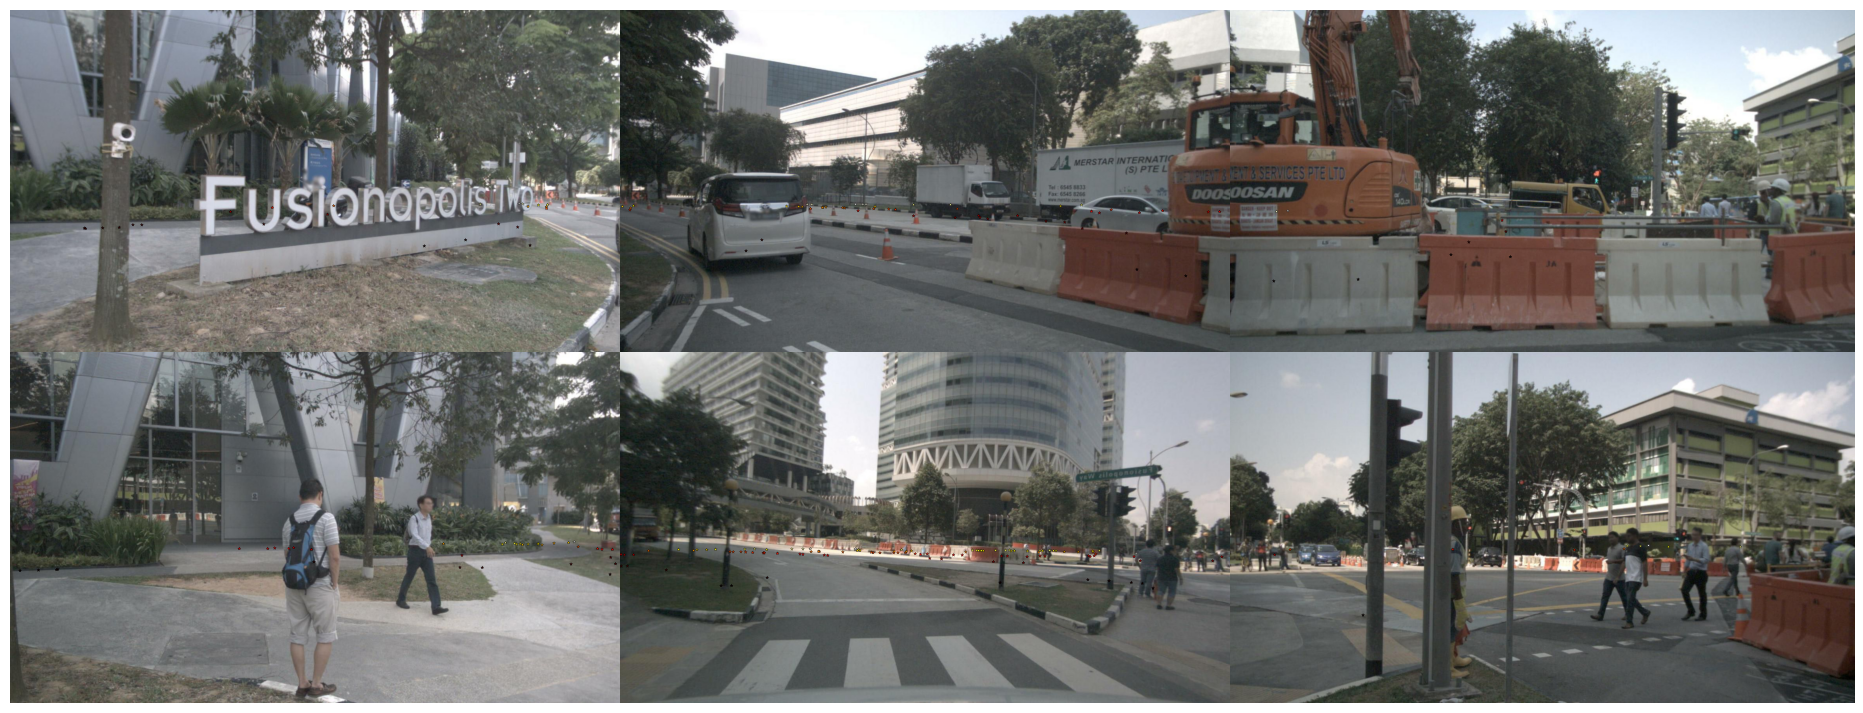

In [4]:
MyRadarPointCloud.default_filters()
nusc.render_pointcloud_in_scene(nusc.sample[index]['token'], nsweeps = nsweeps, show_both_modality=False, verbose=True)

In [11]:
def visualize_3d(index=0, nsweeps=1, rgb_radar=[1,0,0], rgb_lidar=[0,0,1],
                 size_radar=1, size_lidar=0.1, height=800, width=800):
    # pts
    radar_pc = nusc.make_points_list('r', index, nsweeps=nsweeps).astype(np.float32)
    lidar_pc = nusc.make_points_list('l', index, nsweeps=nsweeps).astype(np.float32)
    print(len(radar_pc))
    # radar pc
    radar_points_buf = pjs.BufferAttribute(array=radar_pc)
    radar_colors_buf = pjs.BufferAttribute(array=np.array([rgb_radar] * len(radar_pc), dtype=np.float32))
    radar_geometry = pjs.BufferGeometry(attributes={'position': radar_points_buf, 'color': radar_colors_buf})
    radar_material = pjs.PointsMaterial(vertexColors='VertexColors', size=size_radar)
    radar_pointCloud = pjs.Points(geometry=radar_geometry, material=radar_material)

    # lidar pc
    lidar_points_buf = pjs.BufferAttribute(array=lidar_pc)
    lidar_colors_buf = pjs.BufferAttribute(array=np.array([rgb_lidar] * len(lidar_pc), dtype=np.float32))
    lidar_geometry = pjs.BufferGeometry(attributes={'position': lidar_points_buf, 'color': lidar_colors_buf})
    lidar_material = pjs.PointsMaterial(vertexColors='VertexColors', size=size_lidar)
    lidar_pointCloud = pjs.Points(geometry=lidar_geometry, material=lidar_material)

    pythreejs_camera = pjs.PerspectiveCamera(up=[1, 0, 1], children=[pjs.DirectionalLight(color='black', intensity=0.5)])
    pythreejs_camera.rotateX(np.pi/4)
    pythreejs_camera.position = (-15., 0., 30.)

    sphere_geometry = pjs.SphereGeometry(radius=51.2, widthSegments=32, heightSegments=16)
    sphere_material = pjs.MeshBasicMaterial(color='red', transparent=True, opacity=0.05)
    
    scene = pjs.Scene(children=[radar_pointCloud, lidar_pointCloud, pythreejs_camera, pjs.AmbientLight(color='#777777')])
    axes = pjs.AxesHelper(size=3)
    sphere = pjs.Mesh(geometry=sphere_geometry, material=sphere_material)
    scene.add(axes)
    scene.add(sphere)
        
    control = pjs.OrbitControls(controlling=pythreejs_camera)
    renderer = pjs.Renderer(camera=pythreejs_camera, scene=scene, width=width, height=height, preserveDrawingBuffer=True, controls=[control])
    
    return renderer


In [ ]:
visualize_3d(index=index, nsweeps=nsweeps, size_radar=1, size_lidar=0.1)

In [7]:
def visualize_radar(index=0, nsweeps=1, rgb_radar=[1,0,0], rgb_radar_removed=[0,1,0],rgb_lidar=[0,0,1],
                 size_radar=1, size_lidar=0.1, height=800, width=800):
    # pts
    MyRadarPointCloud.default_filters()
    radar_pc = nusc.make_points_list('r', index, nsweeps=nsweeps).astype(np.float32)
    MyRadarPointCloud.filtered_pts()
    removed_radar_pc = nusc.make_points_list('r', index, nsweeps=nsweeps).astype(np.float32)
    lidar_pc = nusc.make_points_list('l', index, nsweeps=nsweeps).astype(np.float32)
    print(len(radar_pc))
    # radar pc
    radar_points_buf = pjs.BufferAttribute(array=radar_pc)
    radar_colors_buf = pjs.BufferAttribute(array=np.array([rgb_radar] * len(radar_pc), dtype=np.float32))
    radar_geometry = pjs.BufferGeometry(attributes={'position': radar_points_buf, 'color': radar_colors_buf})
    radar_material = pjs.PointsMaterial(vertexColors='VertexColors', size=size_radar)
    radar_pointcloud = pjs.Points(geometry=radar_geometry, material=radar_material)
    # removed radar pc
    removed_radar_points_buf = pjs.BufferAttribute(array=removed_radar_pc)
    removed_radar_colors_buf = pjs.BufferAttribute(array=np.array([rgb_radar_removed] * len(removed_radar_pc), dtype=np.float32))
    removed_radar_geometry = pjs.BufferGeometry(attributes={'position': removed_radar_points_buf, 'color': removed_radar_colors_buf})
    removed_radar_material = pjs.PointsMaterial(vertexColors='VertexColors', size=size_radar)
    removed_radar_pointcloud = pjs.Points(geometry=removed_radar_geometry, material=removed_radar_material)
    # lidar pc
    lidar_points_buf = pjs.BufferAttribute(array=lidar_pc)
    lidar_colors_buf = pjs.BufferAttribute(array=np.array([rgb_lidar] * len(lidar_pc), dtype=np.float32))
    lidar_geometry = pjs.BufferGeometry(attributes={'position': lidar_points_buf, 'color': lidar_colors_buf})
    lidar_material = pjs.PointsMaterial(vertexColors='VertexColors', size=size_lidar)
    lidar_pointCloud = pjs.Points(geometry=lidar_geometry, material=lidar_material)

    pythreejs_camera = pjs.PerspectiveCamera(up=[1, 0, 1], children=[pjs.DirectionalLight(color='black', intensity=0.5)])
    pythreejs_camera.rotateX(np.pi/4)
    pythreejs_camera.position = (-15., 0., 30.)

    sphere_geometry = pjs.SphereGeometry(radius=51.2, widthSegments=32, heightSegments=16)
    sphere_material = pjs.MeshBasicMaterial(color='red', transparent=True, opacity=0.05)
    
    scene = pjs.Scene(children=[radar_pointcloud,removed_radar_pointcloud, lidar_pointCloud, pythreejs_camera, pjs.AmbientLight(color='#777777')])
    axes = pjs.AxesHelper(size=3)
    sphere = pjs.Mesh(geometry=sphere_geometry, material=sphere_material)
    scene.add(axes)
    scene.add(sphere)
        
    control = pjs.OrbitControls(controlling=pythreejs_camera)
    renderer = pjs.Renderer(camera=pythreejs_camera, scene=scene, width=width, height=height, preserveDrawingBuffer=True, controls=[control])
    
    return renderer


In [ ]:
visualize_radar(index=243, nsweeps=1, rgb_radar=[1,0,0], rgb_radar_removed=[0,1,0],rgb_lidar=[0,0,1],
                 size_radar=1, size_lidar=0.1, height=800, width=800)

In [15]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.lines import Line2D
from matplotlib.patches import Circle
from PIL import Image
from new_methods.MyRadarPointCloud import MyRadarPointCloud as MyRadarPointCloud

def visualize_2d(index=0, nsweeps=1, rgb_default='k', rgb_invalid='g', rgb_ambig='c', rgb_dynprop='m',
                 pts_size=5, axes_limit=100, savepath=None, verbose=False):
    # pts
    MyRadarPointCloud.default_filters()
    default_radar_pc = nusc.make_points_list('r', index, nsweeps=nsweeps).astype(np.float32)
    default_pts = len(default_radar_pc)
    MyRadarPointCloud.removed_invalid_states()
    removed_invalid_pc = nusc.make_points_list('r', index, nsweeps=nsweeps).astype(np.float32)
    invalid_pts = len(removed_invalid_pc)
    MyRadarPointCloud.removed_dynprop_states()
    removed_dynprop_pc = nusc.make_points_list('r', index, nsweeps=nsweeps).astype(np.float32)
    dynprop_pts = len(removed_dynprop_pc)
    MyRadarPointCloud.removed_ambig_states()
    removed_ambig_pc = nusc.make_points_list('r', index, nsweeps=nsweeps).astype(np.float32)
    ambig_pts = len(removed_ambig_pc)

    pc_x = []
    pc_y = []
    pc_size = []
    pc_color = []

    record = nusc.get('sample', nusc.sample[index]['token'])
    radar_data = {}

    for channel, token in record['data'].items():
        sd_record = nusc.get('sample_data', token)
        radar_data[channel] = token

    for i, (_, sd_token) in enumerate(radar_data.items()):
        sd_record = nusc.get('sample_data', sd_token)
        sample_rec = nusc.get('sample', sd_record['sample_token'])
        ref_sd_token = sample_rec['data']['LIDAR_TOP']
        _, boxes, _ = nusc.get_sample_data(ref_sd_token, use_flat_vehicle_coordinates=True)

    for i in range(len(default_radar_pc)):
        if abs(default_radar_pc[i][0]) < 100.0 and abs(default_radar_pc[i][1]) < 100.0:
            pc_x.append(default_radar_pc[i][0])
            pc_y.append(default_radar_pc[i][1])
            pc_size.append(pts_size)
            pc_color.append(rgb_default)

    for j in range(len(removed_invalid_pc)):
        if abs(removed_invalid_pc[j][0]) < 100.0 and abs(removed_invalid_pc[j][1]) < 100.0:
            pc_x.append(removed_invalid_pc[j][0])
            pc_y.append(removed_invalid_pc[j][1])
            pc_size.append(pts_size)
            pc_color.append(rgb_invalid)

    for k in range(len(removed_dynprop_pc)):
        if abs(removed_dynprop_pc[k][0]) < 100.0 and abs(removed_dynprop_pc[k][1]) < 100.0:
            pc_x.append(removed_dynprop_pc[k][0])
            pc_y.append(removed_dynprop_pc[k][1])
            pc_size.append(pts_size)
            pc_color.append(rgb_dynprop)

    for l in range(len(removed_ambig_pc)):
        if abs(removed_ambig_pc[l][0]) < 100.0 and abs(removed_ambig_pc[l][1]) < 100.0:
            pc_x.append(removed_ambig_pc[l][0])
            pc_y.append(removed_ambig_pc[l][1])
            pc_size.append(pts_size)
            pc_color.append(rgb_ambig)
            
    #rotate 90 deg CCW
    X = [-1*x for x in pc_y]
    Y = pc_x

    fig = plt.figure(figsize=(10, 10))
    ax = fig.subplots()
    ax.set_xlim(-axes_limit, axes_limit)
    ax.set_ylim(-axes_limit, axes_limit)
    ax.axis('off')
    ax.set_aspect('equal')
    ax.scatter(x=X, y=Y, s=pc_size, c=pc_color, zorder=4)
    ax.plot(0, 0, 'x', color='red', zorder = 4)

    legend_elements = [
        Line2D([0], [0], marker='o', color='w', markerfacecolor=rgb_default, markersize=10, label='Default'),
        Line2D([0], [0], marker='o', color='w', markerfacecolor=rgb_invalid, markersize=10, label='Invalid'),
        Line2D([0], [0], marker='o', color='w', markerfacecolor=rgb_dynprop, markersize=10, label='Dynprop'),
        Line2D([0], [0], marker='o', color='w', markerfacecolor=rgb_ambig, markersize=10, label='Ambig')
    ]

    # Add legend
    ax.legend(handles=legend_elements, loc='upper left')

    rotation_matrix = np.array([[0, -1, 0], [1, 0, 0], [0, 0, 1]])
    for box in boxes:
        c = np.array(nusc.colormap[box.name]) / 255.0
        box.render(ax, view=rotation_matrix, colors=(c, c, c))

    for r in range(10, axes_limit + 1, 10):  # 10m부터 시작하여 10m 간격 circle
        if r == 50:
            color_circle = 'red'
            linewidth_circle = 0.7
        else:
            color_circle = 'blue'
            linewidth_circle = 0.3
        circle = Circle((0, 0), r, color=color_circle, fill=False, linewidth=linewidth_circle)
        ax.add_patch(circle)

    nusc.explorer.render_ego_centric_map_modified(sample_data_token=sd_token, rotation= 90.0, axes_limit=axes_limit, ax=ax)

    ax.text(0.99, 0.92, f'Default: {default_pts}\nInvalid: {invalid_pts}\nDynprop: {dynprop_pts}\nAmbig: {ambig_pts}', 
            verticalalignment='bottom', horizontalalignment='right', 
            transform=ax.transAxes, color='black', fontsize=10,
            bbox=dict(facecolor='white', alpha=0.8, edgecolor='none'))
    if verbose:
        plt.show()
    if savepath is not None:
        plt.savefig(fname=savepath, format='png', bbox_inches='tight')

In [7]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.patches import Circle
from PIL import Image

#Outdated: Using visualize_2d() is recommended

def filtercomparison_2D(index=0, nsweeps=1, rgb_removed=[0, 1, 0], rgb_filtered=[0, 0, 1],
                 size_radar=5, axes_limit=100, savepath=None, verbose=False):
    # Disable filters and get unfiltered radar points
    MyRadarPointCloud.default_filters()
    default_radar_pc = nusc.make_points_list('r', index, nsweeps=nsweeps).astype(np.float32)
    total_pts = len(default_radar_pc)
    
    # Enable filters and get filtered radar points
    MyRadarPointCloud.default_filters()
    filtered_radar_pc = nusc.make_points_list('r', index, nsweeps=nsweeps).astype(np.float32)

    # Find points in unfiltered_radar_pc but not in filtered_radar_pc
    filtered_set = set(map(tuple, filtered_radar_pc))
    removed_points = np.array([pt for pt in default_radar_pc if tuple(pt) not in filtered_set])
    removed_pts = len(removed_points)

    pc_x = []
    pc_y = []
    pc_size = []
    pc_color = []

    record = nusc.get('sample', nusc.sample[index]['token'])
    radar_data = {}

    for channel, token in record['data'].items():
        sd_record = nusc.get('sample_data', token)
        radar_data[channel] = token

    for _, sd_token in radar_data.items():
        sd_record = nusc.get('sample_data', sd_token)
        sample_rec = nusc.get('sample', sd_record['sample_token'])
        ref_sd_token = sample_rec['data']['LIDAR_TOP']
        _, boxes, _ = nusc.get_sample_data(ref_sd_token, use_flat_vehicle_coordinates=True)

    # Plot filtered points
    for point in filtered_radar_pc:
        if abs(point[0]) < 100.0 and abs(point[1]) < 100.0:
            pc_x.append(point[0])
            pc_y.append(point[1])
            pc_size.append(size_radar)
            pc_color.append(rgb_filtered)

    # Plot removed points
    for point in removed_points:
        if abs(point[0]) < 100.0 and abs(point[1]) < 100.0:
            pc_x.append(point[0])
            pc_y.append(point[1])
            pc_size.append(size_radar)
            pc_color.append(rgb_removed)

    fig = plt.figure(figsize=(10, 10))
    ax = fig.subplots()
    ax.scatter(x=pc_x, y=pc_y, s=pc_size, c=pc_color)
    ax.set_xlim(-axes_limit, axes_limit)
    ax.set_ylim(-axes_limit, axes_limit)
    ax.axis('off')
    ax.set_aspect('equal')
    ax.plot(0, 0, 'x', color='red')

    for box in boxes:
        c = np.array(nusc.colormap[box.name]) / 255.0
        box.render(ax, view=np.eye(4), colors=(c, c, c))

    for r in range(10, axes_limit + 1, 10):  # 10m부터 시작하여 10m 간격 circle
        if r == 50:
            color_circle = 'red'
            linewidth_circle = 0.7
        else:
            color_circle = 'blue'
            linewidth_circle = 0.3
        circle = Circle((0, 0), r, color=color_circle, fill=False, linewidth=linewidth_circle)
        ax.add_patch(circle)
    
    nusc.explorer.render_ego_centric_map(sample_data_token=sd_token, axes_limit=axes_limit, ax=ax)

    # Add text to display the number of points
    ax.text(0.97, 0.03, f'Total: {total_pts}\nRemoved: {removed_pts}', 
            verticalalignment='bottom', horizontalalignment='right', 
            transform=ax.transAxes, color='black', fontsize=12, 
            rotation=270,
            bbox=dict(facecolor='white', alpha=0.8, edgecolor='none'))

    if savepath is not None:
        plt.savefig(fname=savepath, format='png', bbox_inches='tight')
        plt.close(fig)
        # Rotate the saved image
        img = Image.open(savepath)
        img_rotated = img.rotate(90, expand=True)
        img_rotated.save(savepath)

        if verbose:
            display(img_rotated)
    elif verbose:
        plt.show()

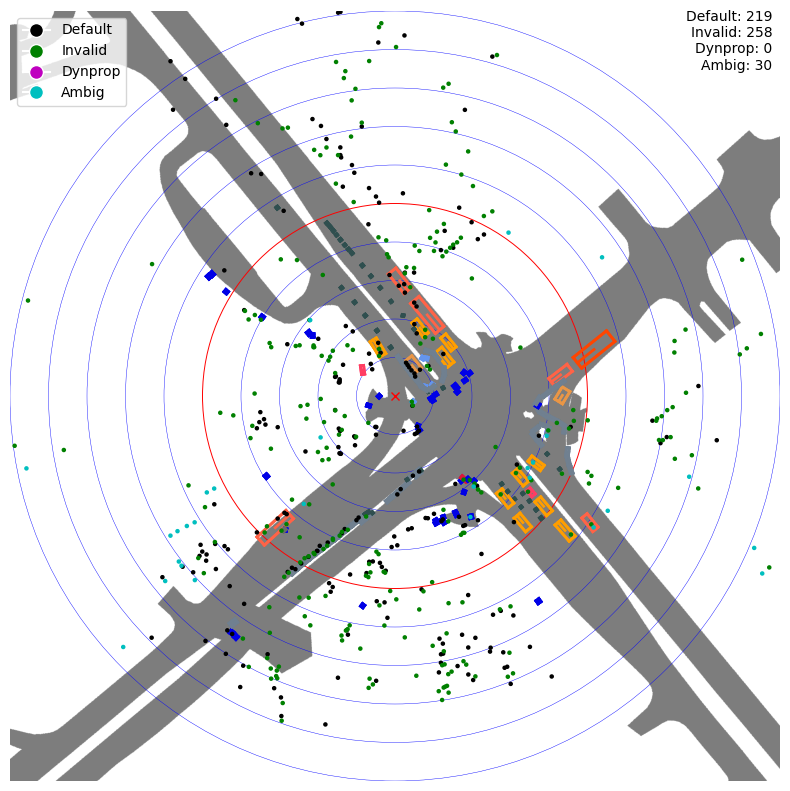

<Figure size 640x480 with 0 Axes>

In [16]:
index = 20
nsweeps = 1

visualize_2d(index=index, nsweeps= nsweeps,
             savepath='/home/cwkim0214/workspace/Nuscenes_tutorial/visualization/Graphs/test.png',
             verbose=True)

In [14]:
import os
base_path = '/home/cwkim0214/workspace/Nuscenes_tutorial/visualization/Graphs/pointcloud_compare'

for index in tqdm(range(len(nusc.sample))):
    img_filename_fmt = os.path.join(base_path,'sample{:03d}.png')
    dirname = os.path.dirname(img_filename_fmt)
    os.makedirs(dirname, exist_ok=True)
    savepath = img_filename_fmt.format(index)
    visualize_2d(index=index, nsweeps=nsweeps, savepath=savepath, verbose=False)

100%|██████████| 404/404 [06:28<00:00,  1.04it/s]


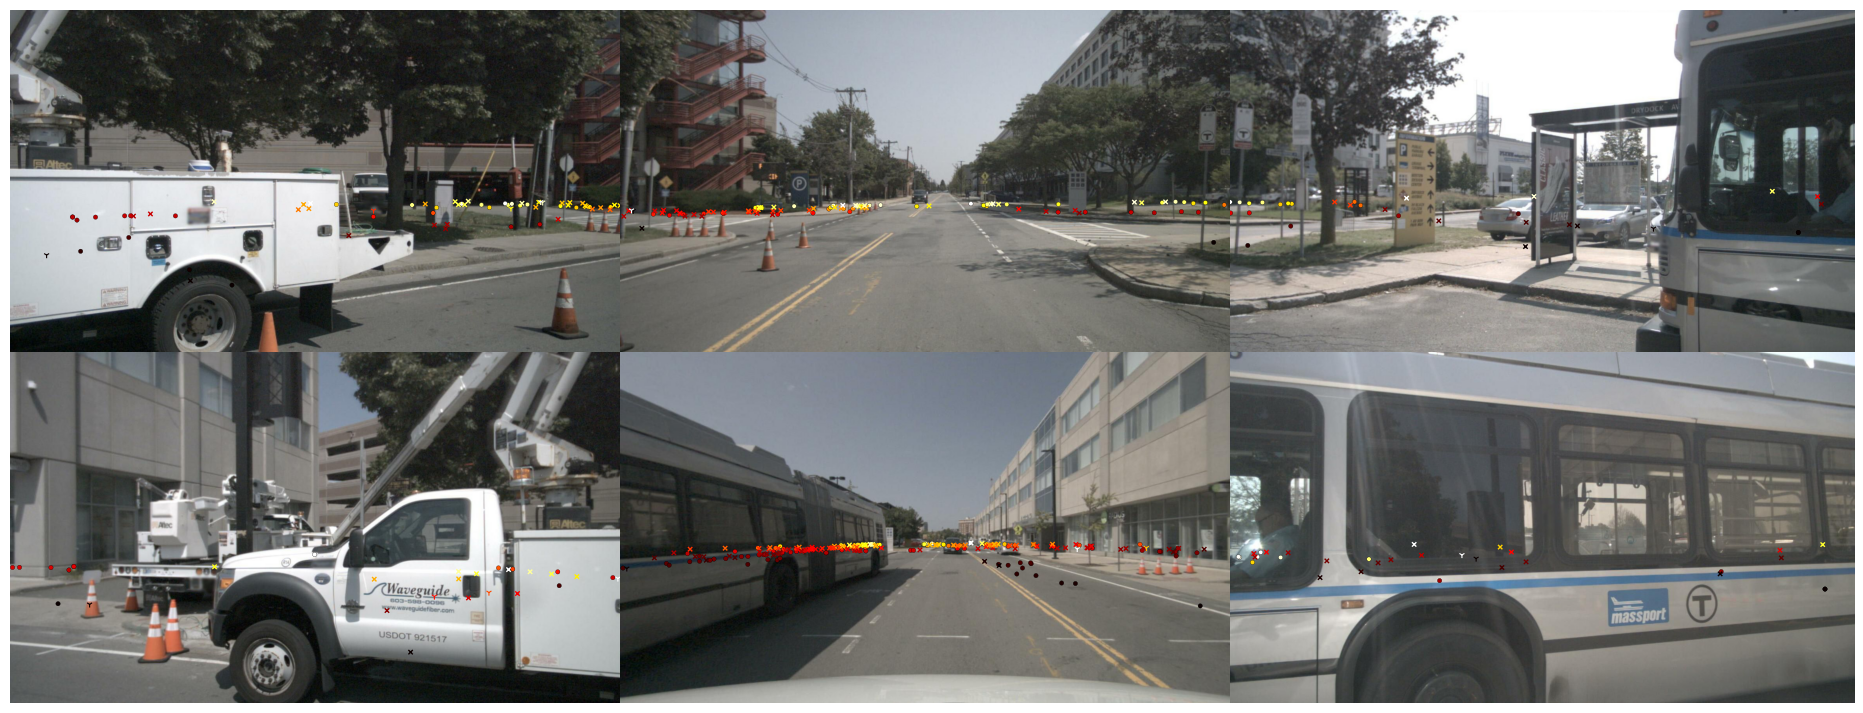

In [2]:
index = 154
nusc.render_radar_pcd_in_scene(sample_token=nusc.sample[index]['token'],
                                dot_size= 10,
                                filt_dot_size= 20,
                                nsweeps=1,
                                pointsensor_channel = None,
                                camera_channel = None, 
                                out_path = None,
                                render_intensity = False,
                                ax= None,
                                verbose = True,
                                show_panoptic = False)

In [3]:
import os
base_path = '/home/cwkim0214/workspace/Nuscenes_tutorial/visualization/Graphs/scene_filter'

for index in tqdm(range(len(nusc.sample))):
    img_filename_fmt = os.path.join(base_path,'scene{:03d}.png')
    dirname = os.path.dirname(img_filename_fmt)
    os.makedirs(dirname, exist_ok=True)
    savepath = img_filename_fmt.format(index)
    nusc.render_radar_pcd_in_scene(sample_token=nusc.sample[index]['token'],
                                    dot_size= 10,
                                    filt_dot_size= 20,
                                    nsweeps=1,
                                    pointsensor_channel = None,
                                    camera_channel = None, 
                                    out_path = savepath,
                                    render_intensity = False,
                                    ax= None,
                                    verbose = False,
                                    show_panoptic = False)

100%|██████████| 404/404 [17:53<00:00,  2.66s/it]


# Find index of validation dataset

In [ ]:
with open('/home/byounghun/workspace/CRN/data/nuScenes/nuscenes_infos_val.pkl', 'rb') as f:
	val_data = pickle.load(f)
with open('/home/byounghun/workspace/CRN/data/nuScenes/nuscenes_infos_train.pkl', 'rb') as f:
	train_data = pickle.load(f)
    
val_sample_list = [d['sample_token'] for d in val_data]
train_sample_list = [d['sample_token'] for d in train_data]

print(len(train_sample_list))
print(len(val_sample_list))
# val_sample_list

In [ ]:
mini_sample_token_list = [sample['token'] for sample in nusc.sample]
val_idx_dict = {}
train_idx_dict = {}

for mini_sample in mini_sample_token_list:
    if mini_sample in val_sample_list:
        idx = val_sample_list.index(mini_sample)
        idx_mini = mini_sample_token_list.index(mini_sample)
        val_idx_dict[idx_mini] = idx
    elif mini_sample in train_sample_list:
        idx = train_sample_list.index(mini_sample)
        idx_mini = mini_sample_token_list.index(mini_sample)
        train_idx_dict[idx_mini] = idx

print(len(val_idx_dict))
print(len(train_idx_dict))

In [ ]:
with open('/home/byounghun/workspace/CRN/val_idx_dict.pkl','wb') as f:
    pickle.dump(val_idx_dict, f)
with open('/home/byounghun/workspace/CRN/train_idx_dict.pkl','wb') as f:
    pickle.dump(train_idx_dict, f)

In [ ]:
with open('/home/byounghun/workspace/CRN/val_idx_dict.pkl', 'rb') as f:
    val_idx_dict = pickle.load(f)
with open('/home/byounghun/workspace/CRN/train_idx_dict.pkl', 'rb') as f:
    train_idx_dict = pickle.load(f)

In [ ]:
train_idx_dict[20]

# Feature Map

In [ ]:
index=203
nsweeps=1

In [ ]:
# for sample no.83 - bad sample
fused_feature_map_list = []
base_feat_path = '/home/byounghun/workspace/CRN/feature_map'
for index in range(4):
    file_name = 'ret_feature_list_np_' + str(index) + '.npy'
    feature_map = np.load(osp.join(base_feat_path, file_name))
    fused_feature_map_list.append(feature_map)
print(len(fused_feature_map_list))
# fused_feature_map_list

In [ ]:
# fused feature map after multi-modal deformable attention
fused_feature_map = fused_feature_map_list[0]
# fused_feature_map

In [ ]:
image_feature_map = np.load(osp.join(base_feat_path, 'img_feature_map_np.npy'))
radar_feature_map = np.load(osp.join(base_feat_path, 'radar_feature_map_np.npy'))

In [ ]:
nusc.render_pointcloud_in_scene(nusc.sample[index]['token'], nsweeps = nsweeps, show_both_modality=True, verbose=True)

In [ ]:
image_name = str(nusc.get('sample',nusc.sample[index]['token'])['timestamp'])+'.png'

pred_result = plt.imread(osp.join('/home/byounghun/workspace/CRN/outputs/det/CRN_r18_256x704_128x128_4key/examples',image_name))
plt.figure(figsize=(10, 10))
plt.imshow(pred_result)
plt.axis('off')
plt.show()

In [ ]:
import pickle
base_file_path = '/home/byounghun/workspace/CRN/bbox_infos'
file_n_gt = 'boxes_gt_' + str(index) + '.pkl'
file_n_est = 'boxes_est_' + str(index) + '.pkl'

with open(osp.join(base_file_path, file_n_gt), 'rb') as f:
    boxes_gt = pickle.load(f)
with open(osp.join(base_file_path, file_n_est), 'rb') as f:
    boxes_est = pickle.load(f)
print(boxes_gt[0])
print(boxes_est[0])

In [ ]:
def draw_corners(ax, boxes, color='green', linewidth=1, th=0.5):
    original_min, original_max = -51.2, 51.2
    original_range = original_max - original_min
    target_min, target_max = 0, 128
    target_range = target_max - target_min

    scale_factor = target_range / original_range
    
    rot_mat = np.array([
    [-1,0,0,0],
    [0,-1,0,0],
    [0,0,1,0],
    [0,0,0,1]])
    
    if not np.isnan(boxes[0].score):
        homo_corners = [np.vstack((box.corners(), np.ones((1, 8)))) for box in boxes if box.score > th]
    else:
        homo_corners = [np.vstack((box.corners(), np.ones((1, 8)))) for box in boxes]
        
    rot_corners_list = [np.dot(homo.T, rot_mat)[:,:3] for homo in homo_corners]
    rot_corners_list_neg_y = [np.array([[-x, y, z] for [x, y, z] in corners]) for corners in rot_corners_list]
    scaled_corners = [np.array([[(x - original_min) * scale_factor,
                                 (y - original_min) * scale_factor,
                                 (z - original_min) * scale_factor] for [x,y,z] in corners]) for corners in rot_corners_list_neg_y]
    for rot_corners in scaled_corners:
        for i in range(4):
            ax.plot([rot_corners[i][0], rot_corners[i + 4][0]],
                      [rot_corners[i][1], rot_corners[i + 4][1]],
                      color=color, linewidth=linewidth)
        def draw_rect(ax, selected_corners, color, linewidth):
            prev = selected_corners[-1]
            for corner in selected_corners:
                ax.plot([prev[0], corner[0]], [prev[1], corner[1]], color=color, linewidth=linewidth)
                prev = corner
        draw_rect(ax, rot_corners[:4], color, linewidth)
        draw_rect(ax, rot_corners[4:], color, linewidth)

        center_bottom_forward = np.mean(rot_corners[2:4], axis=0)
        center_bottom = np.mean(rot_corners[[2, 3, 7, 6]], axis=0)
        ax.plot([center_bottom[0], center_bottom_forward[0]],
                  [center_bottom[1], center_bottom_forward[1]],
                  color=color, linewidth=linewidth)

In [ ]:
# 초기 설정
th = 0.5
linewidth_gt = 0.5
linewidth_est = 0.3
color_gt = 'black'
color_est = 'red'
axes_limit = 127.5

# 모든 feature channel에서 mean값 계산하여 2D BEV map 생성
image_feature_map_mean = np.mean(image_feature_map[0, :, :, :], axis=0)
image_feature_map_mean_normalized = (image_feature_map_mean - np.min(image_feature_map_mean)) / (np.max(image_feature_map_mean) - np.min(image_feature_map_mean))
image_rotated_map = np.rot90(image_feature_map_mean_normalized, k=1)
image_mirrored_map = image_rotated_map[:, ::-1]

radar_feature_map_mean = np.mean(radar_feature_map[0, :, :, :], axis=0)
radar_feature_map_mean_normalized = (radar_feature_map_mean - np.min(radar_feature_map_mean)) / (np.max(radar_feature_map_mean) - np.min(radar_feature_map_mean))
radar_rotated_map = np.rot90(radar_feature_map_mean_normalized, k=1)
radar_mirroed_map = radar_rotated_map[:, ::-1]

fused_feature_map_mean = np.mean(fused_feature_map[0, :, :, :], axis=0)
fused_feature_map_mean_normalized = (fused_feature_map_mean - np.min(fused_feature_map_mean)) / (np.max(fused_feature_map_mean) - np.min(fused_feature_map_mean))
fused_rotated_map = np.rot90(fused_feature_map_mean_normalized, k=1)
fused_mirrored_map = fused_rotated_map[:, ::-1]

fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(15, 5))

im0 = axes[0].imshow(image_mirrored_map, cmap='viridis')
draw_corners(axes[0], boxes_gt, color=color_gt, linewidth=linewidth_gt, th=th)
draw_corners(axes[0], boxes_est, color=color_est, linewidth=linewidth_est, th=th)
axes[0].plot(64, 64, marker='x', color='red', markersize=5)
axes[0].set_title('Image Feature Map')
axes[0].set_xlim(-0.5, axes_limit)
axes[0].set_ylim(axes_limit, -0.5)
# axes[0].axis('off')
fig.colorbar(im0, ax=axes[0], fraction=0.046, pad=0.04)

im1 = axes[1].imshow(radar_mirroed_map, cmap='viridis')
axes[1].set_title('Radar Feature Map')
draw_corners(axes[1], boxes_gt, color=color_gt, linewidth=linewidth_gt, th=th)
draw_corners(axes[1], boxes_est, color=color_est, linewidth=linewidth_est, th=th)
axes[1].plot(64, 64, marker='x', color='red', markersize=5)
axes[1].set_xlim(-0.5, axes_limit)
axes[1].set_ylim(axes_limit, -0.5)
# axes[1].axis('off')
fig.colorbar(im1, ax=axes[1], fraction=0.046, pad=0.04)

im2 = axes[2].imshow(fused_mirrored_map, cmap='viridis')
axes[2].set_title('Fused Feature Map')
draw_corners(axes[2], boxes_gt, color=color_gt, linewidth=linewidth_gt, th=th)
draw_corners(axes[2], boxes_est, color=color_est, linewidth=linewidth_est, th=th)
axes[2].plot(64, 64, marker='x', color='red', markersize=5)
axes[2].set_xlim(-0.5, axes_limit)
axes[2].set_ylim(axes_limit, -0.5)
# # axes[2].axis('off')
fig.colorbar(im2, ax=axes[2], fraction=0.046, pad=0.04)

plt.suptitle('BEV Feature Map (Mean feature)')
plt.savefig('/home/byounghun/workspace/CRN/feature_map/BEV_Feature_Map.png')
plt.show()

# Distance distribution

In [ ]:
index = [20]

In [ ]:
radar_distance_total = []
lidar_distance_total = []

for index in tqdm(range(len(index))):
    default_radar_pc = nusc.make_points_list('r', index, nsweeps=1).astype(np.float32)
    lidar_pc = nusc.make_points_list('l', index, nsweeps=1).astype(np.float32)

    radar_distance = [mt.sqrt(mt.pow(default_radar_pc[i][0], 2) + mt.pow(default_radar_pc[i][1], 2) + mt.pow(default_radar_pc[i][2], 2)) for i in range(len(default_radar_pc))]
    lidar_distance = [mt.sqrt(mt.pow(lidar_pc[i][0], 2) + mt.pow(lidar_pc[i][1], 2) + mt.pow(lidar_pc[i][2], 2)) for i in range(len(lidar_pc))]

    radar_distance_total.extend(radar_distance)
    lidar_distance_total.extend(lidar_distance)

In [ ]:
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(10,12))
bins = 100
hist_r, bin_edges_r = np.histogram(radar_distance_total, bins=bins, range=(0,250))#, density=True)
hist_l, bin_edges_l = np.histogram(lidar_distance_total, bins=bins, range=(0,250))#, density=True)

bar_centers_r = bin_edges_r[:-1] + np.diff(bin_edges_r) / 2
axes[0].bar(bar_centers_r, hist_r, width=np.diff(bin_edges_r), edgecolor='black')

bar_centers_l = bin_edges_l[:-1] + np.diff(bin_edges_l) / 2
plt.bar(bar_centers_l, hist_l, width=np.diff(bin_edges_l), edgecolor='black')

axes[0].set_xlabel('distance of radar pointcloud')
axes[0].set_ylabel('number of radar pointcloud')
# plt.ylim(0,20)
# plt.yticks(np.arange(0,21,1))
axes[0].set_title('number of radar pointcloud in mini samples')

axes[1].set_xlabel('distance of radar pointcloud')
axes[1].set_ylabel('number of radar pointcloud')
# plt.ylim(0,20)
# plt.yticks(np.arange(0,21,1))
axes[1].set_title('number of lidar pointcloud in mini samples')

In [ ]:
count = 0
for distance in radar_distance_total:
    if distance > 51.2:
        count += 1
long_range_percentage_radar = count*100/len(radar_distance_total)
long_range_percentage_radar

In [ ]:
count = 0
for distance in lidar_distance_total:
    if distance > 51.2:
        count += 1
long_range_percentage_lidar = count*100/len(lidar_distance_total)
long_range_percentage_lidar